Create a SVD low-rank model of the noise data, for each of the three time periods. The model should be based on the whole time period, and the results reported for each time period. Compare this with a "global model" which is based on the ensemble average of all stations over each of the three time periods. In additional, compare the global model to ensemble averages and SVD low-rank models for each of the four regions. In total, you will have five resulting models: one global model with all regions + four regional models using station data from each region.

Time periods:
Day: 07:00-19:00
Evening: 19:00-23:00
Night: 23:00-07:00

Execute the following cell to connect your google drive to the colab. Needed to load the data stored on your personal google drive. In case you use a local environment just comment out the following lines of code.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive = True

Mounted at /content/drive


In [2]:
import pandas as pd
import os
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [3]:
if drive is not None and drive:
  dir_path = '/content/drive/MyDrive/data/'
else :
  dir_path = './data/'

folders = ['region_1_mustamäe_kristiine', 'region_2_data_kesklinn', 'region_3_kadriorg_lasnamäe', 'region_4_ülemiste']

list_df = []
sensor_names = []
region_list = []

for folder in folders:
    for file in os.listdir(dir_path + folder):
        sensor_name = file.split('-')[0]
        region_list.append(int(folder.split('_')[1]))
        sensor_names.append(file.split('-')[0])
        df = pd.read_csv(dir_path + folder + "/" + file, index_col=None, header=0)
        df['Time'] = df.apply(lambda row: datetime.strptime(row['Time'], '%Y-%m-%d %H:%M:%S'), axis=1)
        df.rename(columns={'dt_sound_level_dB': sensor_name}, inplace=True)
        list_df.append(df)

In [4]:
start_time = datetime.strptime('2022.08.01 00:00:00', '%Y.%m.%d %H:%M:%S')
end_time = datetime.strptime('2022.08.13 23:59:00', '%Y.%m.%d %H:%M:%S')

df_counter = 0

for df in list_df:
    df = df[df.Time >= start_time]
    df = df[df.Time <= end_time]

    start_row = pd.DataFrame({'Time': start_time, 'dt_sound_level_dB': df.iloc[0][sensor_names[df_counter]]}, index=[0])
    start_row['Time'] = pd.to_datetime(start_row['Time'])

    end_row = pd.DataFrame({'Time': end_time, sensor_names[df_counter]: df.iloc[-1][sensor_names[df_counter]]}, index=[0])
    end_row['Time'] = pd.to_datetime(end_row['Time'])

    df['Time'] = pd.to_datetime(df['Time'])
    df = df.set_index('Time')

    if not (df.index == end_time).any():
        df.loc[end_time] = [df.iloc[-1][sensor_names[df_counter]]]

    if not (df.index == start_time).any():
        df.loc[start_time] = [df.iloc[0][sensor_names[df_counter]]]

    df = df.sort_values(by='Time')
    df_counter += 1
    # print(df.head())
    # print(df.tail())
    # print("--------------------------------------------------")


<ipython-input-4-cda4b83f5cd3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.to_datetime(df['Time'])
<ipython-input-4-cda4b83f5cd3>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Time'] = pd.to_datetime(df['Time'])


In [5]:
import datetime

dt = start_time
step = datetime.timedelta(minutes=1)
result = []

while dt < end_time:
    result.append(dt.strftime('%Y.%m.%d %H:%M:%S'))
    dt += step

col = {'Time': result, 'dummy': 0}
df_all_timestamps = pd.DataFrame(data=col)
df_all_timestamps['Time'] = pd.to_datetime(df_all_timestamps['Time'])
df_all_timestamps = df_all_timestamps.set_index('Time')

print(df_all_timestamps.head())

del df_counter, dt, start_time, end_time

                     dummy
Time                      
2022-08-01 00:00:00      0
2022-08-01 00:01:00      0
2022-08-01 00:02:00      0
2022-08-01 00:03:00      0
2022-08-01 00:04:00      0


In [6]:
list_df_inter = []
df_counter = 0
df_all_data = df_all_timestamps.drop('dummy', axis=1)

for df in list_df:
    df = df_all_timestamps.merge(df, how='left', on='Time')
    df = df.drop('dummy', axis=1)

    while df[sensor_names[df_counter]].isnull().values.any():
        df = df.interpolate(method='bfill', limit=1)
        df = df.interpolate(method='ffill', limit=1)

    df = df.set_index('Time')
    df = df.resample('1T').mean()
    df_counter += 1
    df_all_data = df_all_data.merge(df, how='left', on='Time')

del df_counter, df_all_timestamps, list_df

In [7]:
d = {'sensor names':sensor_names,'region':region_list}
sensors = pd.DataFrame(d)
sensors_region1 = sensors[sensors['region'] == 1]['sensor names']
sensors_region2 = sensors[sensors['region'] == 2]['sensor names']
sensors_region3 = sensors[sensors['region'] == 3]['sensor names']
sensors_region4 = sensors[sensors['region'] == 4]['sensor names']

# print(df_all_data[sensors_region1])

In [8]:
def calc_SVD_RMSE(df):
    U, s, Vt = np.linalg.svd(df)

    rank_range = range(1, len(df.columns) + 1)
    rmse_list = []
    amount_sing_values = []

    for rank in rank_range:
        Sigma = np.zeros((df.shape[0], df.shape[1]))
        Sigma[:rank, :rank] = np.diag(s[:rank])
        df_recon = U.dot(Sigma.dot(Vt))

        rmse = np.sqrt(np.mean((df - df_recon)**2))
        rmse_list.append(rmse.mean())
        amount_sing_values.append(Sigma[rank-1][rank-1])

    return rmse_list, amount_sing_values
    

In [9]:
df_all_data.reset_index(inplace=True)
df_without_timestamp = df_all_data.iloc[:, 1:len(df_all_data.columns)+1]

rmse_list_all_regions, amount_sing_val_all_regions = calc_SVD_RMSE(df_without_timestamp)
rmse_list_reg1, amount_sing_val_reg1 = calc_SVD_RMSE(df_without_timestamp[sensors_region1])
rmse_list_reg2, amount_sing_val_reg2 = calc_SVD_RMSE(df_without_timestamp[sensors_region2])
rmse_list_reg3, amount_sing_val_reg3 = calc_SVD_RMSE(df_without_timestamp[sensors_region3])
rmse_list_reg4, amount_sing_val_reg4 = calc_SVD_RMSE(df_without_timestamp[sensors_region4])

def print_values(description, rmse_values, sing_values, steps):
  print()
  print(description)
  for rank in range(len(rmse_values)):
    if rank % steps == 0:
      print(f'Rank: {rank+1} RMSE: {rmse_values[rank]} Amount Singular Values: {sing_values[rank]}')

print_values('All sensor data:', rmse_list_all_regions, amount_sing_val_all_regions, 7)
print_values('Region 1:', rmse_list_reg1, amount_sing_val_reg1, 4)
print_values('Region 2:', rmse_list_reg2, amount_sing_val_reg2, 6)
print_values('Region 3:', rmse_list_reg3, amount_sing_val_reg3, 4)
print_values('Region 4:', rmse_list_reg4, amount_sing_val_reg4, 1)


All sensor data:
Rank: 1 RMSE: 3.577233681905648 Amount Singular Values: 118753.58648618436
Rank: 8 RMSE: 3.039342566561746 Amount Singular Values: 919.4888664963376
Rank: 15 RMSE: 2.8868369922209927 Amount Singular Values: 737.5758903008182
Rank: 22 RMSE: 2.765225061205192 Amount Singular Values: 649.6501685733854
Rank: 29 RMSE: 2.6577986762511743 Amount Singular Values: 602.2596270695667
Rank: 36 RMSE: 2.5580482435002927 Amount Singular Values: 573.1787307538309
Rank: 43 RMSE: 2.463791517133993 Amount Singular Values: 541.0002793820192
Rank: 50 RMSE: 2.3742781402673345 Amount Singular Values: 520.9224507251245
Rank: 57 RMSE: 2.2873862806413157 Amount Singular Values: 502.6182219827278
Rank: 64 RMSE: 2.204103142503863 Amount Singular Values: 485.7082089170635
Rank: 71 RMSE: 2.1214968570583834 Amount Singular Values: 471.7678065272635
Rank: 78 RMSE: 2.041090192328283 Amount Singular Values: 455.56054434707556
Rank: 85 RMSE: 1.961513087377342 Amount Singular Values: 441.95074082490834


In [10]:
amount_sing_val_reg1[0] = amount_sing_val_reg1[1] * 2
amount_sing_val_reg2[0] = amount_sing_val_reg2[1] * 2
amount_sing_val_reg3[0] = amount_sing_val_reg3[1] * 2
amount_sing_val_reg4[0] = amount_sing_val_reg4[1] * 2
amount_sing_val_all_regions[0] = amount_sing_val_all_regions[1] * 2

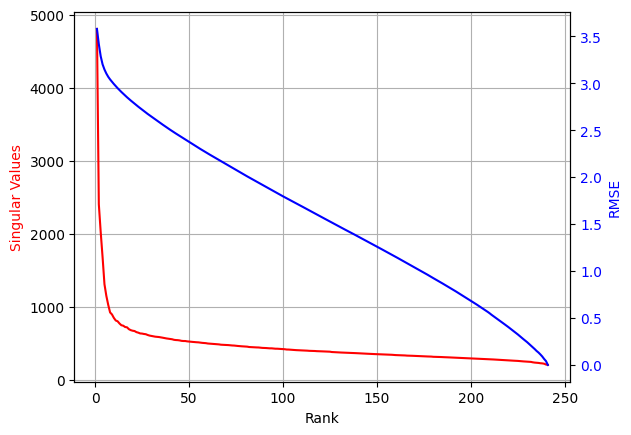

In [11]:
def init_ax(ax, rank_values, rmse_values, sing_values, color1, color2):
  ax.set_xlabel('Rank')
  ax.set_ylabel('Singular Values', color=color1)
  ax.plot(rank_values, sing_values, color=color1)
  ax2 = ax.twinx()
  ax2.set_ylabel('RMSE', color=color2)
  ax2.plot(rank_values, rmse_values, color=color2)
  ax2.tick_params(axis='y', labelcolor=color2)
  ax.grid(True)
  ax2.grid(False)
  return ax

color1 = 'r'
color2 = 'b'

rank_range_all_regions = range(1, len(rmse_list_all_regions) + 1)

fig, ax = plt.subplots()
ax = init_ax(ax, rank_range_all_regions, rmse_list_all_regions, amount_sing_val_all_regions, color1, color2)
plt.show()


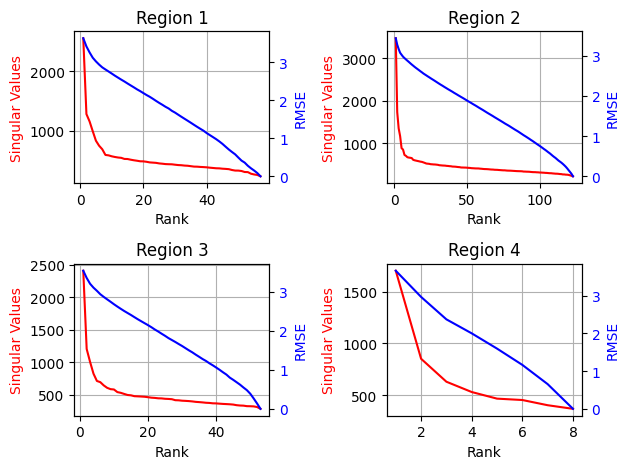

In [12]:
rank_range_reg1 = range(1, len(rmse_list_reg1) + 1)
rank_range_reg2 = range(1, len(rmse_list_reg2) + 1)
rank_range_reg3 = range(1, len(rmse_list_reg3) + 1)
rank_range_reg4 = range(1, len(rmse_list_reg4) + 1)

fig, ax = plt.subplots(2,2)
ax[0, 0] = init_ax(ax[0, 0], rank_range_reg1, rmse_list_reg1, amount_sing_val_reg1, color1, color2)
ax[0, 1] = init_ax(ax[0, 1], rank_range_reg2, rmse_list_reg2, amount_sing_val_reg2, color1, color2)
ax[1, 0] = init_ax(ax[1, 0], rank_range_reg3, rmse_list_reg3, amount_sing_val_reg3, color1, color2)
ax[1, 1] = init_ax(ax[1, 1], rank_range_reg4, rmse_list_reg4, amount_sing_val_reg4, color1, color2)

ax[0, 0].set_title('Region 1')
ax[0, 1].set_title('Region 2')
ax[1, 0].set_title('Region 3')
ax[1, 1].set_title('Region 4')

fig.tight_layout()
plt.show()

Presentation Content:

Choose the kth final rank, and explain why you choose that particular value.

Provide a figure showing the singular values vs. RMSE (compared with the global and regional models) for each of the three time periods, and use it to justify your kth rank.

Select at least three different stations based on their location in the city, choose each station from a different region.

Apply one or more of the SVD models made in the previous steps of the individual different stations chosen in the previous step by randomly sub-sampling your data matrix. Compare the results to your kth rank SVD model using the RMSE and the median absolute deviation.